In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import arviz as az
import theano 
from scipy.stats import norm
from scipy.stats import t
import math
import itertools

from matplotlib import pyplot as plt
from pandas.plotting import scatter_matrix

%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Configuration

In [129]:
remove_rows_not_cells    = True

tracesize                = 50_000
h1_tune_size             = 1000 # default
h1_target_accept         = 0.8  # default
h2_tune_size             = 5000
h2_target_accept         = 0.95

#h1
h1_do_obs                = True
h1_do_bern               = True
resample_h1_obs          = False
resample_h1_bern         = False
folderName_h1_obs        = "h1_obs.trace"
folderName_h1_bern       = "h1_bern.trace"

#h2
h2_do_linear             = True
h2_do_quadratic          = True
resample_h2_linear       = False
resample_h2_quadratic    = False
folderName_h2_linear     = "h2_linear.trace"
folderName_h2_quadratic  = "h2_quadratic.trace"

describeData             = False

h1_ropes                 = list(itertools.product(["diff_μ"], [(-4, -0), (-4, -1), (-4, -2)]))
h1_bern_ropes            = list(itertools.product(["diff_μ"], [(0, 0.5), (0, ((4-1.0)/4.0)*0.5), (0, ((4-2.0)/4.0)*0.5)]))
var_names_h1_notRope     = ['log10_ν', 'μ', 'σ', 'diff_σ', 'eff_size', "eff_size2"]
var_names_h1_all         = var_names_h1_notRope.copy().extend([name for name,rope in h1_ropes])

In [3]:
print(h1_ropes)

[('diff_μ', (-4, 0)), ('diff_μ', (-4, -1)), ('diff_μ', (-4, -2))]


# Helperfunctions

In [4]:
def flatten(lst):
    res = []
    for inner in lst:
        for v in inner:
            res.append(v)
    return res

def getIndexV29(): return 0
def getIndexV31(): return 1
def getIndexV33(): return 2

In [105]:
def getTrace(folder_name, model_name, resample, tune_size, target_accept):
    with model_name:
        if (resample):
            trace = pm.sample(tracesize, chains=4, tune=tune_size, cores=1, step=pm.NUTS(target_accept=target_accept))  #todo argue for choice
            pm.save_trace(trace, folder_name, overwrite=True)
        trace = pm.load_trace(folder_name)
        return trace

def getInferenceData(trace, model_name):
    with model_name:
        return az.from_pymc3(trace, model = model_name)

def standardize(data, m, sd):
    return (data-m)/sd

In [6]:
def plot_trace_method1(trace_inferencedata, var_names, ropes):
    az.plot_posterior(trace_inferencedata, var_names=var_names, kind='hist', figsize=(8,6)
                      , point_estimate='mean', hdi_prob=0.95);
    for rope_vals in ropes:
        if len(rope_vals) == 2:
            (name, rope) = rope_vals
            plot_rope(trace_inferencedata, name, rope, 8, 2.5)
        else:
            (name, rope, height, width) = rope_vals
            plot_rope(trace_inferencedata, name, rope, height, width)
        
def plot_rope(trace_inferencedata, name, rope, width, height):
    az.plot_posterior(trace_inferencedata, var_names=[name], kind='hist', figsize=(width,height)
                      , point_estimate='mean', hdi_prob=0.95, ref_val=0, rope=rope)
        
def plot_trace_method2(trace, model, var_names):
    az.plot_trace(az.from_pymc3(trace,model=model), var_names=var_names);

def plot_trace_scatter(trace, varnames):
    scatter_matrix(pm.trace_to_dataframe(trace, varnames=varnames), figsize=(20, 10));

def plot_all_data(f_x):
    fig,ax = plt.subplots(figsize=(25,20))
    xprime = np.linspace(1,5,80)
    for i in np.random.randint(0,len(trace_h2_linear),100):
        ax.plot(xprime, f_x(xprime, i), color='lightsteelblue')

    # Define spectrum of colors
    number_of_plots=len(communities)
    colormap = plt.cm.nipy_spectral
    colors = [colormap(i) for i in np.linspace(0, 1,number_of_plots)]
    ax.set_prop_cycle('color', colors)

    [ax.plot(get_relevant(com, getIndexV29())[1], get_relevant(com, getIndexV31())[1], "-", marker='o', label=com) for com in communities]

    plt.legend(loc='best')
    plt.show()
def plot_trace_method2(trace, model, var_names):
    az.plot_trace(az.from_pymc3(trace,model=model), var_names=var_names);

def plot_trace_scatter(trace, varnames, width = 20, height = 10):
    scatter_matrix(pm.trace_to_dataframe(trace, varnames=varnames), figsize=(width, height));

def plot_all_data(f_x):
    fig,ax = plt.subplots(figsize=(25,20))
    xprime = np.linspace(1,5,80)
    for i in np.random.randint(0,len(trace_h2_linear),100):
        ax.plot(xprime, f_x(xprime, i), color='lightsteelblue')

    # Define spectrum of colors
    number_of_plots=len(communities)
    colormap = plt.cm.nipy_spectral
    colors = [colormap(i) for i in np.linspace(0, 1,number_of_plots)]
    ax.set_prop_cycle('color', colors)

    [ax.plot(get_relevant(com, getIndexV29())[1], get_relevant(com, getIndexV31())[1], "-", marker='o', label=com) for com in communities]

    plt.legend(loc='best')
    plt.show()

In [179]:
def plot_com_reg_data(com_id, trace, num_ppc, ax, f_x):    
    V29_to_plot = np.array(get_relevant(communities[com_id], getIndexV29())[1])
    xprime = np.linspace(1,5,len(V29_to_plot))
    
    # Plot hdi
    az.plot_hdi(xprime,
                [t.rvs(df=trace[i]['ν'],
                       loc=f_x(xprime, i, com_id), 
                       scale=trace[i]['σ'])
                 for i in np.random.randint(low=0, high=len(trace), size=num_ppc)],
                color='lightblue',
                hdi_prob=0.95,
                ax=ax)
    
    for i in np.random.randint(0,len(trace_h2_linear),num_ppc):
        ax.plot(xprime, f_x(xprime, i, com_id), color='lightgreen')
        
    ax.plot(get_relevant(communities[com_id], getIndexV29())[1], get_relevant(communities[com_id], getIndexV31())[1],
             marker='o',linestyle=None,color='black',lw=0,
             label=communities[com_id])
#     ax.plot(get_relevant(com_id, 2)[1], get_relevant(com, 4)[1], "-", marker='o', color='black',lw=.8, label=com_id)


    ax.set_xlim(1,5)
    ax.set_ylim(-1,5)
    ax.set_title(communities[com_id])
    
def plot_individual(trace, f_x):
    fig, axs = plt.subplots(nrows=3,ncols=5, figsize=(20,12))
    flatten_axs = axs.ravel()
    [plot_com_reg_data(com_id=com_id,trace=trace,num_ppc=100,ax=ax,f_x=f_x) for (com_id,ax) in zip(com_ids,flatten_axs)]
    [flatten_axs[i].axis('off') for i in range(len(com_ids),len(flatten_axs))]
    plt.show()

# load data

In [8]:
# TODO: DF each for H1 and H2

In [9]:
df = pd.read_csv('pseudonymized-data.csv')
df = df.rename(columns={df.columns[0]: 'id'})

df = df[["id", "Community", "V29", "V31", "V33"]]
df = df[df["Community"] != "-1"]

if remove_rows_not_cells:
    for col in df.iloc[:,2:].columns:
        df = df[df[col] != -1]

In [10]:
def removeNoAnswer(lst):
    return lst if remove_rows_not_cells else [i for i in lst if i!=-1]

data = []
communities = df.Community.unique();
for com in communities:
    columns  = []
    for question in df.iloc[:,2:].columns:
        columns.append(removeNoAnswer(df[df.Community == com][question].to_numpy()))
    positive = [[0.5 if d==3 else int(d<=3) for d in v] for v in columns]

    N = [len(v) for v in columns]
    μ = [np.mean(v) for v in columns]
    σ = [np.std(v) for v in columns]
    
    N_bern = [len(v) for v in positive]
    μ_bern = [np.mean(v) for v in positive]
    σ_bern = [np.std(v) for v in positive]
    all = (com, columns, positive, N, μ, σ, N_bern, μ_bern, σ_bern)
    data.append(all)

def get_all_data ():
    return data
    
def get_relevant(com, dataIndex):
    (com, columns, positive, N, μ, σ, N_bern, μ_bern, σ_bern) = next(filter(lambda lst : lst[0]==com, data))
    return (com, columns[dataIndex], positive[dataIndex], N[dataIndex], μ[dataIndex], σ[dataIndex], N_bern[dataIndex], μ_bern[dataIndex], σ_bern[dataIndex])

In [11]:
df.head() if describeData else None

In [12]:
df.iloc[:,2:].describe() if describeData else None

In [13]:
if describeData:
    df.hist(column=df.columns[1:], bins=50, figsize=(20,3), layout=(1,3))
    plt.show()

# H1
The Coala Community is more lenient than the Linux Kernel Community.

The decision rules for the hypothesis that the Coala Community is more lenient than the Linux Kernel Community is as follows:  
The Likert scale value of Coala community is lower than that of Linux Kernel Community for question V33. 2 models have been created one comparing the unaltered data and one where data have been converted to a scale where 1,2 =0, 3=0.5 and 4,5=1.

In [14]:
(com_coala, obs_coala, bern_coala, N_coala_obs, μ_coala_obs, σ_coala_obs, N_coala_bern, μ_coala_bern, σ_coala_bern)=get_relevant("Comm.Coala", getIndexV33())
(com_linux, obs_linux, bern_linux, N_linux_obs, μ_linux_obs, σ_linux_obs, N_linux_bern, μ_linux_bern, σ_linux_bern)=get_relevant("Comm.Linux_Kernel", getIndexV33())

if describeData  or True:
    print("com: ",com_coala, com_linux)
    print("obs: ",obs_coala, obs_linux)
    print("N: ", N_coala_obs, N_linux_obs)
    print("μ: ", μ_coala_obs, μ_linux_obs)
    print("σ: ", σ_coala_obs, σ_linux_obs)
    print("p: ", bern_coala, bern_linux)
    print("N: ", N_coala_bern, N_linux_bern)
    print("μ: ", μ_coala_bern, μ_linux_bern)
    print("σ: ", σ_coala_bern, σ_linux_bern)

com:  Comm.Coala Comm.Linux_Kernel
obs:  [2 1 2 2 1 2 2] [2 4 4 3 3 1 2 3 2 3 3 4 3 4 2 2 3 4]
N:  7 18
μ:  1.7142857142857142 2.888888888888889
σ:  0.45175395145262565 0.8748897637790901
p:  [1, 1, 1, 1, 1, 1, 1] [1, 0, 0, 0.5, 0.5, 1, 1, 0.5, 1, 0.5, 0.5, 0, 0.5, 0, 1, 1, 0.5, 0]
N:  7 18
μ:  1.0 0.5277777777777778
σ:  0.0 0.38987969021161667


### H1 Model description

In [15]:
def makeModel(data_coala, data_linux, data_μ_coala, data_μ_linux, data_σ_coala, data_σ_linux):
    data_σ_coala = np.max([1/1000,data_σ_coala])
    data_σ_linux = np.max([1/1000,data_σ_linux])
    with pm.Model() as model_h1:
        μ_noData = pm.Normal('μ_noData', mu=1, sigma=100*1, shape=2)
        μ        = pm.Deterministic('μ', μ_noData*[data_μ_coala, data_μ_linux])
        σ_noData = pm.Uniform('σ_noData', lower=1/1000, upper=1*1000, shape=2)
        σ        = pm.Deterministic('σ', σ_noData*[data_σ_coala, data_σ_linux])
        ν_minus_one = pm.Exponential('ν_minus_one', lam=1/29)
        ν = pm.Deterministic('ν', ν_minus_one+1)

        # for plotting/comparison purposes
        log10_ν = pm.Deterministic('log10_ν',np.log10(ν))
        eff_size = pm.Deterministic('eff_size',(μ-100)/σ)
        
        eff_size2 = pm.Deterministic('eff_size2',((μ[0]-μ[1])/np.sqrt((σ[0]**2+σ[1]**2)/2)))
        
        #likelihood
        obs_coala   = pm.StudentT('obs_coala',  nu=ν, mu=μ[0], sd=σ[0], observed=data_coala)
        obs_linux   = pm.StudentT('obs_linux',  nu=ν, mu=μ[1], sd=σ[1], observed=data_linux)

        #differences
        diff_μ   = pm.Deterministic('diff_μ', μ[0]-μ[1])
        diff_σ   = pm.Deterministic('diff_σ', σ[0]-σ[1])
    return model_h1

In [16]:
model_h1_obs  = makeModel(obs_coala,  obs_linux,  μ_coala_obs,  μ_linux_obs,  σ_coala_obs,  σ_linux_obs)  if h1_do_obs else None
model_h1_bern = makeModel(bern_coala, bern_linux, μ_coala_bern, μ_linux_bern, σ_coala_bern, σ_linux_bern) if h1_do_bern else None

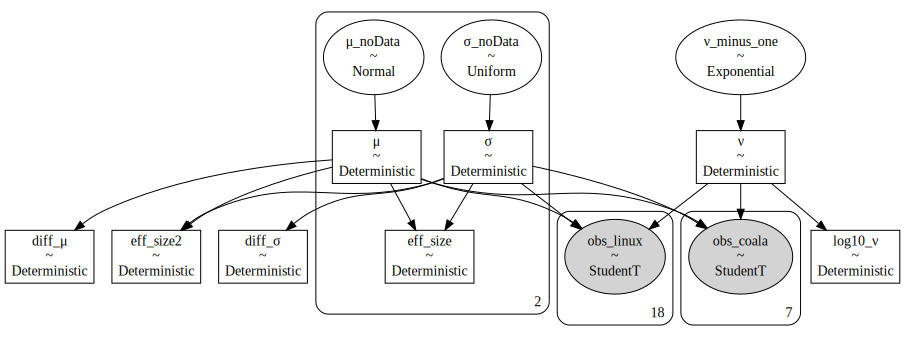

In [17]:
pm.model_to_graphviz(model_h1_obs)  if h1_do_obs else None

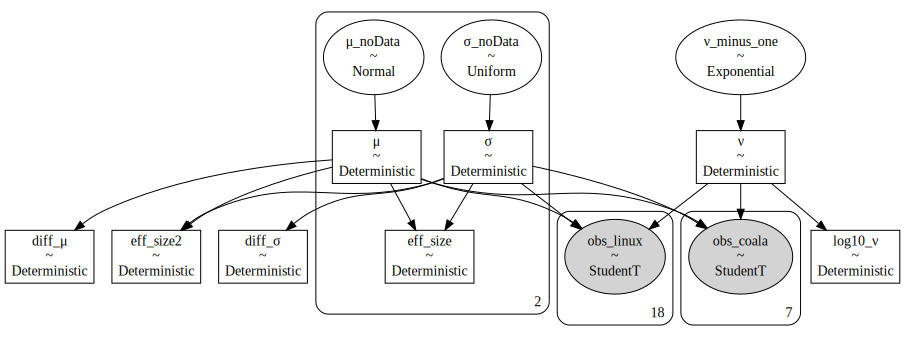

In [49]:
pm.model_to_graphviz(model_h1_bern) if h1_do_bern else None

## Model arguments
The model consists of 3 things we wish to observe. The mean of both questions, the scale of both questions and the value of the normalizer.  
The prior on  mean μ is chosen to be a normal placed in the middle of the data and its sigma got set to a large value such that the prior has minimal influence. For the prior on the standard deviation whereas a gamma prior could have been used we went with a broad uniform instead. Just like with the mean the values were chosen such that the prior has minimal effect on the posterior.  
The likelihood was first decided to be done using a normal. However, a T estimation/student-t was used instead to add robust estimation. The T estimation uses a combined normalizer parameter was as the dataset is small and using the same for both makes the normality more stable for estimation.  
The primary result is the `diff_μ` which is computed as the computed μ for the coalas - the μ for the linux community. Effective sample size of the difference was also added in order to better conclude any results.

In [70]:
trace_h1_obs = getTrace(folderName_h1_obs,  model_h1_obs,  resample_h1_obs, h1_tune_size, h1_target_accept)  if h1_do_obs else None
trace_h1_inferencedata_obs = getInferenceData(trace_h1_obs, model_h1_obs)    if h1_do_obs else None

Sequential sampling (4 chains in 1 job)
NUTS: [ν_minus_one, σ_noData, μ_noData]


Sampling 4 chains for 1_000 tune and 50_000 draw iterations (4_000 + 200_000 draws total) took 148 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


In [71]:
trace_h1_bern = getTrace(folderName_h1_bern, model_h1_bern, resample_h1_bern, h1_tune_size, h1_target_accept) if h1_do_bern else None
trace_h1_inferencedata_bern = getInferenceData(trace_h1_bern, model_h1_bern)  if h1_do_bern else None

Sequential sampling (4 chains in 1 job)
NUTS: [ν_minus_one, σ_noData, μ_noData]


Sampling 4 chains for 1_000 tune and 50_000 draw iterations (4_000 + 200_000 draws total) took 177 seconds.


### H1 Sampling analysis

In [72]:
az.summary(trace_h1_obs)  if h1_do_obs  else None

C:\ProgramData\Miniconda3\lib\site-packages\arviz\data\io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
μ_noData[0]    1.011   0.152    0.727    1.292      0.001    0.000   85420.0   
μ_noData[1]    1.003   0.081    0.852    1.160      0.000    0.000  131062.0   
μ[0]           1.733   0.261    1.246    2.214      0.001    0.001   85420.0   
μ[1]           2.899   0.235    2.460    3.352      0.001    0.000  131062.0   
σ_noData[0]    1.359   0.607    0.558    2.427      0.002    0.002   72270.0   
σ_noData[1]    1.078   0.217    0.706    1.487      0.001    0.000  113490.0   
σ[0]           0.614   0.274    0.252    1.096      0.001    0.001   72270.0   
σ[1]           0.943   0.190    0.618    1.301      0.001    0.000  113490.0   
ν_minus_one   35.291  30.418    0.146   90.174      0.078    0.055  153095.0   
ν             36.291  30.418    1.146   91.174      0.078    0.055  153095.0   
log10_ν        1.412   0.381    0.691    2.089      0.002    0.001   60570.0   
eff_size[0] -185.384  73.284 -303.177  -66.886      0.652    0.726   12639.0   
eff_size[1] -106.961  20.774 -144.920  -68.779      0.081    0.074   65285.0   
eff_size2     -1.494   0.501   -2.431   -0.541      0.002    0.001   93463.0   
diff_μ        -1.166   0.350   -1.827   -0.512      0.001    0.001  106406.0   
diff_σ        -0.329   0.330   -0.916    0.273      0.001    0.001   91701.0   

               ess_sd  ess_bulk  ess_tail  r_hat  
μ_noData[0]   85420.0  103013.0   91984.0    1.0  
μ_noData[1]  130211.0  132836.0  111985.0    1.0  
μ[0]          85420.0  103013.0   91984.0    1.0  
μ[1]         130211.0  132836.0  111985.0    1.0  
σ_noData[0]   63817.0   56290.0   36818.0    1.0  
σ_noData[1]  113490.0  108811.0   78999.0    1.0  
σ[0]          63817.0   56290.0   36818.0    1.0  
σ[1]         113490.0  108811.0   78999.0    1.0  
ν_minus_one  153095.0   69408.0   34160.0    1.0  
ν            153095.0   69408.0   34160.0    1.0  
log10_ν       60570.0   69408.0   34160.0    1.0  
eff_size[0]    5089.0   56293.0   36829.0    1.0  
eff_size[1]   38991.0  108844.0   79820.0    1.0  
eff_size2     64340.0  103168.0   94523.0    1.0  
diff_μ        96329.0  115411.0  106732.0    1.0  
diff_σ        76028.0  109034.0  101789.0    1.0

In [73]:
az.summary(trace_h1_bern) if h1_do_bern else None

C:\ProgramData\Miniconda3\lib\site-packages\arviz\data\io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean            sd        hdi_3%       hdi_97%  \
μ_noData[0]  1.000000e+00  0.000000e+00  1.000000e+00  1.000000e+00   
μ_noData[1]  1.003000e+00  2.000000e-01  6.270000e-01  1.383000e+00   
μ[0]         1.000000e+00  0.000000e+00  1.000000e+00  1.000000e+00   
μ[1]         5.290000e-01  1.060000e-01  3.310000e-01  7.300000e-01   
σ_noData[0]  1.000000e-03  0.000000e+00  1.000000e-03  2.000000e-03   
σ_noData[1]  1.094000e+00  2.150000e-01  7.260000e-01  1.495000e+00   
σ[0]         0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
σ[1]         4.270000e-01  8.400000e-02  2.830000e-01  5.830000e-01   
ν_minus_one  3.819300e+01  3.085900e+01  1.149000e+00  9.409000e+01   
ν            3.919300e+01  3.085900e+01  2.149000e+00  9.509000e+01   
log10_ν      1.465000e+00  3.490000e-01  8.030000e-01  2.093000e+00   
eff_size[0] -8.249509e+07  1.390605e+07 -9.899999e+07 -5.652645e+07   
eff_size[1] -2.417220e+02  4.495500e+01 -3.267640e+02 -1.590710e+02   
eff_size2    1.616000e+00  4.570000e-01  7.680000e-01  2.482000e+00   
diff_μ       4.710000e-01  1.060000e-01  2.700000e-01  6.690000e-01   
diff_σ      -4.270000e-01  8.400000e-02 -5.830000e-01 -2.830000e-01   

             mcse_mean    mcse_sd  ess_mean    ess_sd  ess_bulk  ess_tail  \
μ_noData[0]      0.000      0.000  121715.0  121715.0  144776.0  115684.0   
μ_noData[1]      0.000      0.000  182554.0  177232.0  185620.0  139491.0   
μ[0]             0.000      0.000  121715.0  121715.0  144776.0  115684.0   
μ[1]             0.000      0.000  182554.0  177232.0  185620.0  139491.0   
σ_noData[0]      0.000      0.000  103390.0   79187.0  122333.0   85802.0   
σ_noData[1]      0.001      0.000  157936.0  145014.0  175272.0  134864.0   
σ[0]             0.000      0.000  103390.0   79187.0  122333.0   85802.0   
σ[1]             0.000      0.000  157936.0  145014.0  175272.0  134864.0   
ν_minus_one      0.071      0.053  187332.0  168594.0  163096.0  125987.0   
ν                0.071      0.053  187332.0  168967.0  163096.0  125987.0   
log10_ν          0.001      0.001  155446.0  155446.0  163096.0  125987.0   
eff_size[0]  36282.613  25655.762  146896.0  146896.0  122332.0   85802.0   
eff_size[1]      0.106      0.075  178214.0  178214.0  175283.0  135302.0   
eff_size2        0.001      0.001  198337.0  198337.0  194190.0  124823.0   
diff_μ           0.000      0.000  182554.0  180142.0  185620.0  139491.0   
diff_σ           0.000      0.000  157936.0  145014.0  175271.0  134864.0   

             r_hat  
μ_noData[0]    1.0  
μ_noData[1]    1.0  
μ[0]           1.0  
μ[1]           1.0  
σ_noData[0]    1.0  
σ_noData[1]    1.0  
σ[0]           1.0  
σ[1]           1.0  
ν_minus_one    1.0  
ν              1.0  
log10_ν        1.0  
eff_size[0]    1.0  
eff_size[1]    1.0  
eff_size2      1.0  
diff_μ         1.0  
diff_σ         1.0

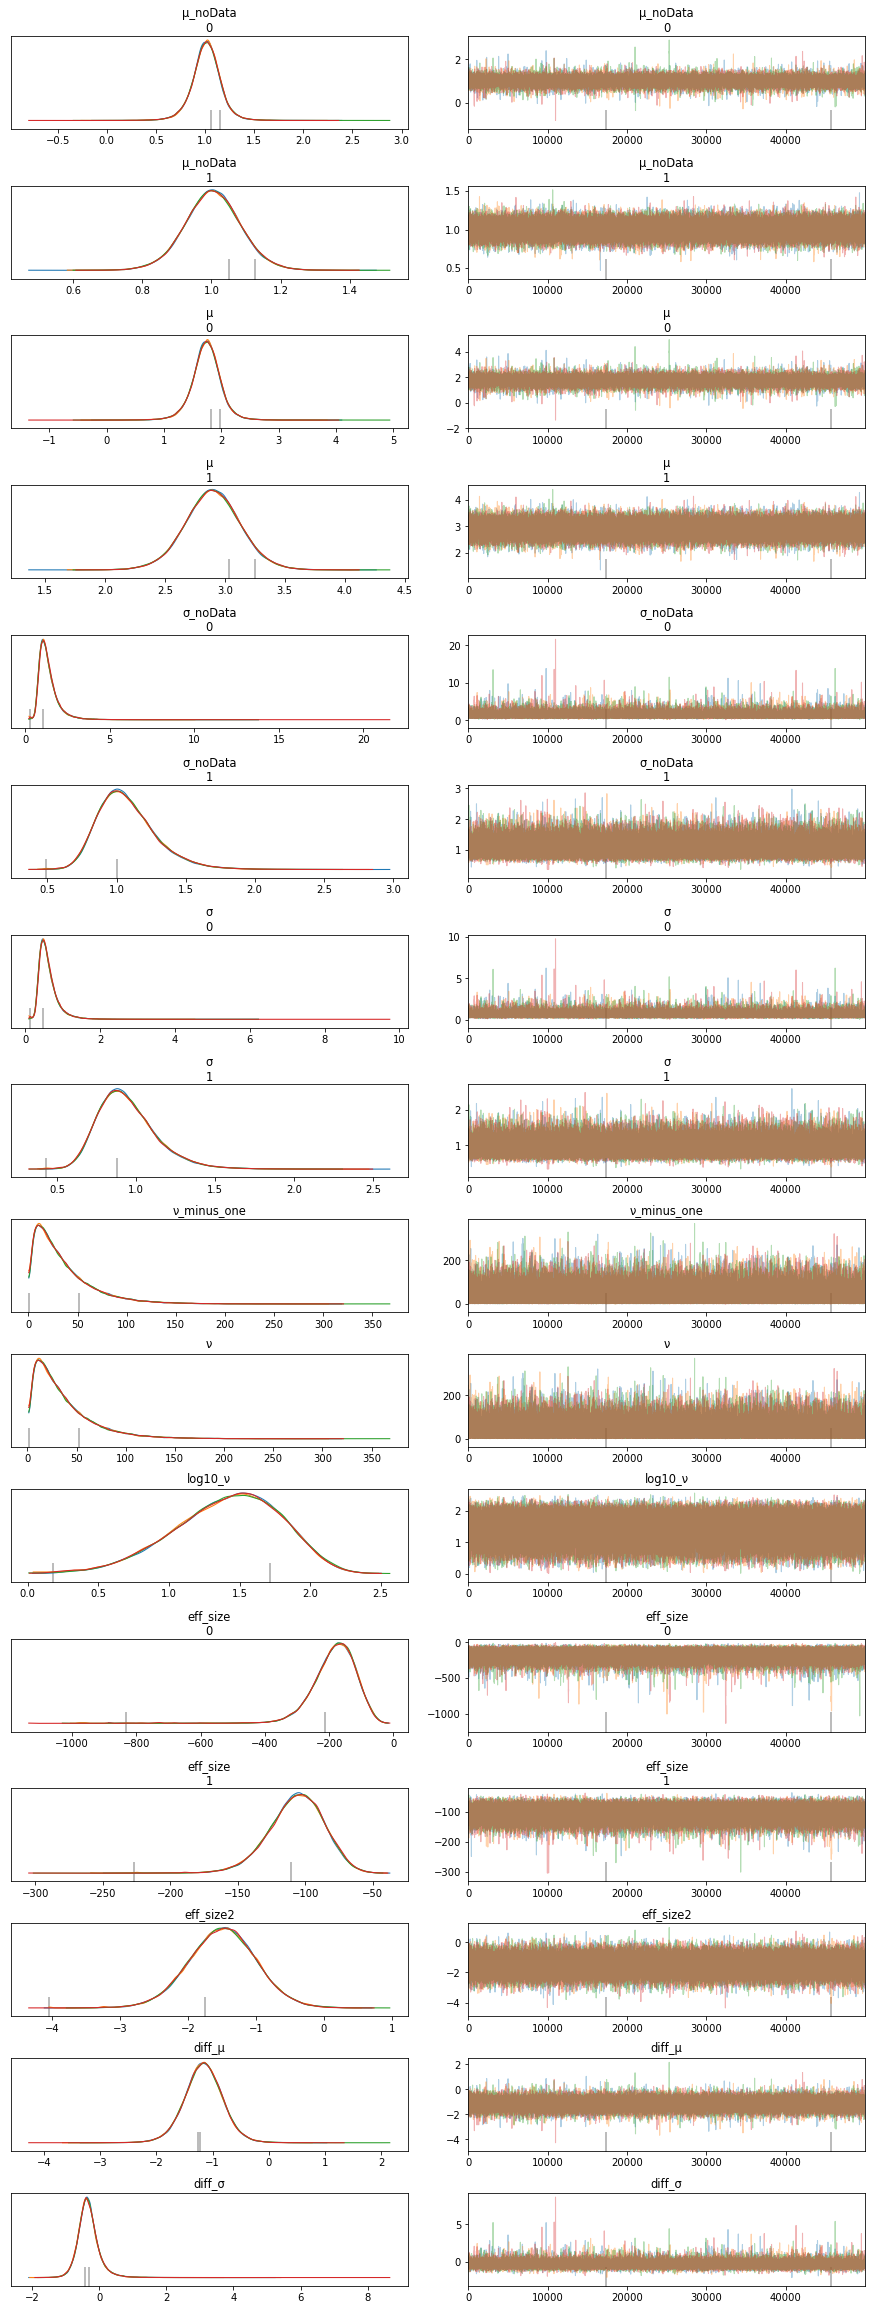

In [74]:
plot_trace_method2(trace_h1_obs, model_h1_obs, var_names_h1_all) if h1_do_obs  else None

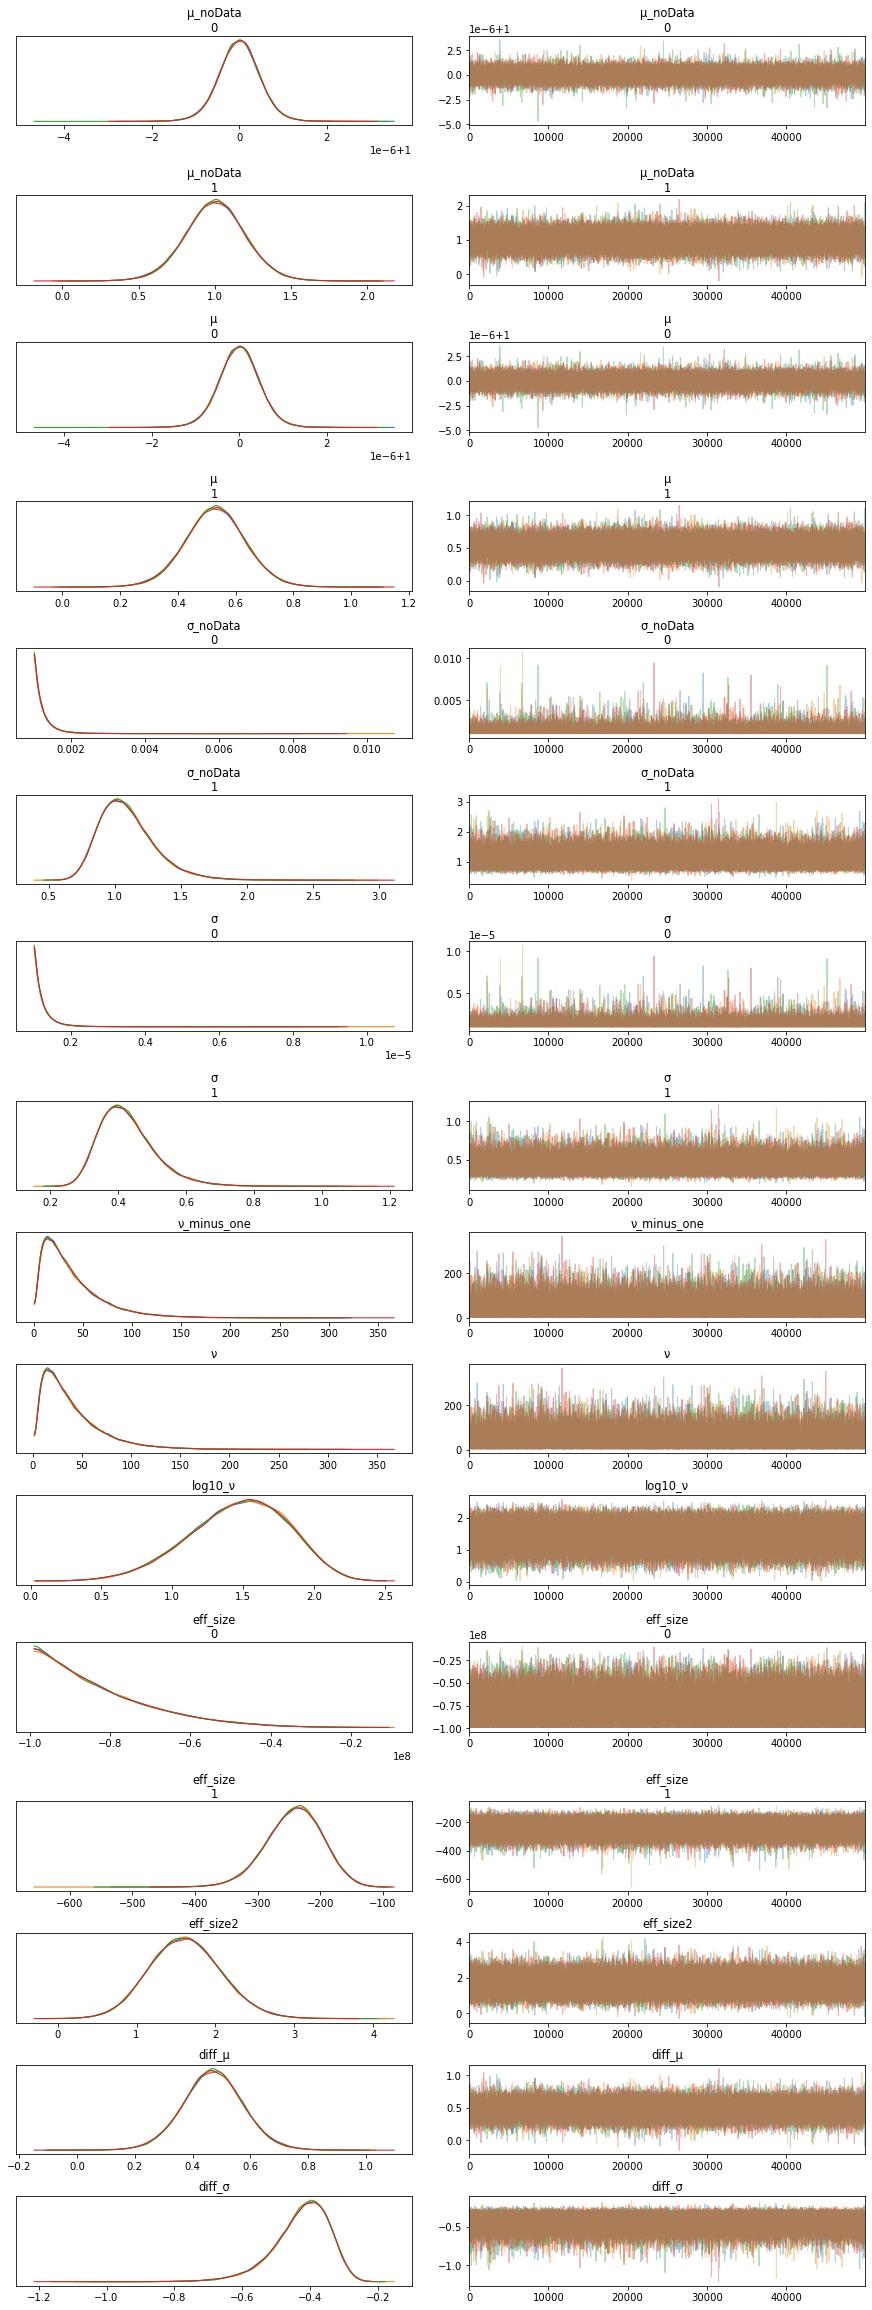

In [75]:
plot_trace_method2(trace_h1_bern, model_h1_bern, var_names_h1_all) if h1_do_bern  else None

#### Sampling effectiveness
The tune used was the default 1000, and the number of cores was set to 1 as we otherwise observed many divergences.  

The convergence diagnostic called r_hat is a generalization of the shrink factor / variance within the chain compared to variance between the chains. As it is 1 for both the original data and the transformed and not above 1.05 there isn’t a need to increase burn-in.  
The visual check of convergence gotten with az.plot_trace method show that the chains are overlapping in the limit and that the densities are overlapping. As there are only 2 black rugplot for the orignal and 0 for the transformed, there aren't sufficient divergences present to cast doubt of the result.  

The effective sample size, which should be close to the sample size tracesize times number of chains, is for all variables larger than 55_000 and therefore also the 10_000 recommended for 95% HDI inference. For the transformed data the ESS is even greater and is between 100_000 and 200_000.
The Monte Carlo standard error / MCSE which indicates the standard deviation of the chain / sqrt(ESS), is also low indicating an effective sampling.  

When testing which sampler to use the best was the no U-turn sampler or the NUTS sampler. The samplers were tested with a tracesize of 10_000, 4 chains and their ESS was compared. For the metropolis, step=pm.Metropolis(), some variables had an ESS lower than 10_000 and for almost all it was lower than 30_000. For the Hamiltonian monte carlo, step=HamiltonianMC(), the ESS was for all variables lower than 20_000.  
The tune size was set by plotting the values over iterations and observing when it starts to flatten out.


## H1 Finds

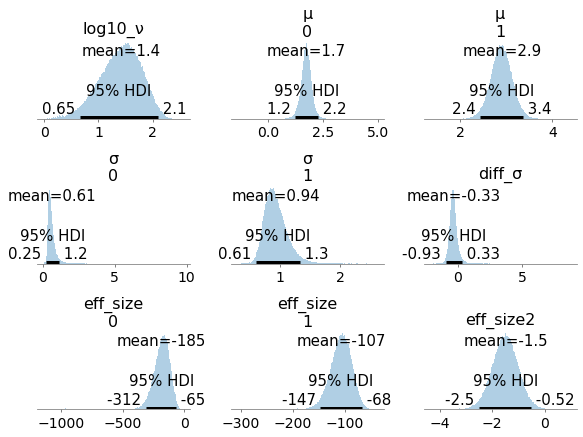

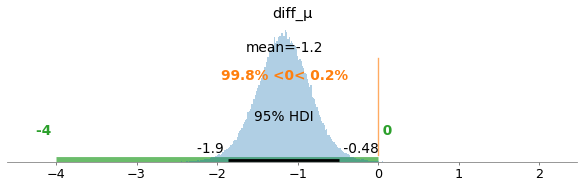

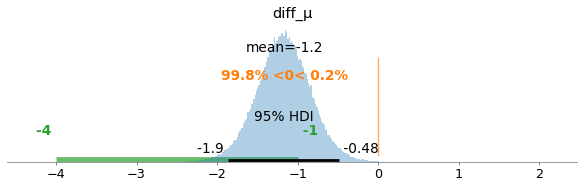

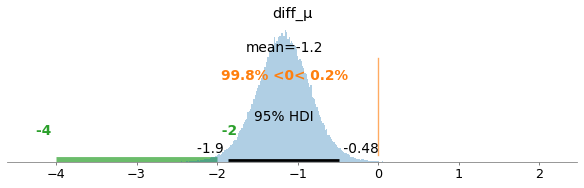

In [77]:
plot_trace_method1(trace_h1_inferencedata_obs,  var_names_h1_notRope, h1_ropes) if h1_do_obs  else None

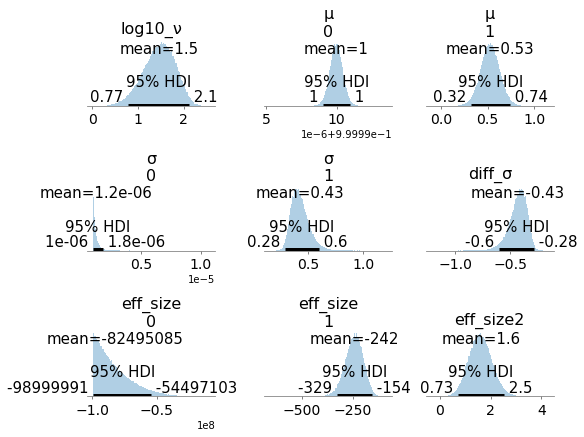

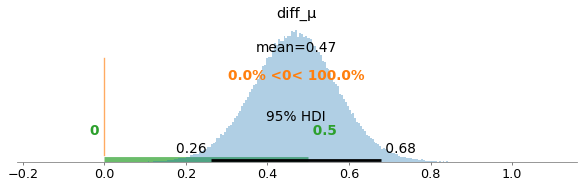

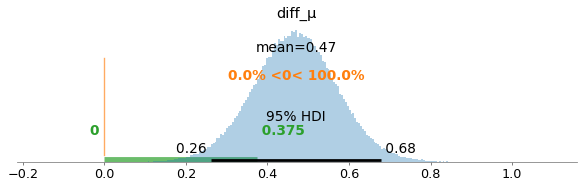

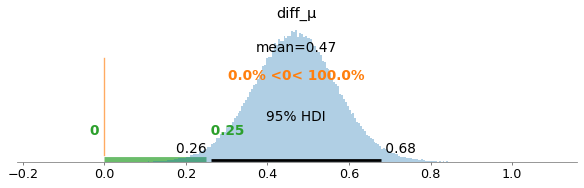

In [76]:
plot_trace_method1(trace_h1_inferencedata_bern, var_names_h1_notRope, h1_bern_ropes) if h1_do_bern else None

In [82]:
# plot_trace_scatter(trace_h1_obs, ['μ_noData', 'μ', 'diff_μ'])

In [83]:
# plot_trace_scatter(trace_h1_bern, ['μ_noData', 'μ', 'diff_μ'])

#### Summary of finds
For both the original and the transformed model, the normalizer v is less than 50. This indicates that in the dataset there are multiple outliers pressent and the t distribution thus differes from the normal it you have been if no outliers were pressent.  
The means fro the Coala is as expected 1 for the transformed and for the original the 95% HDI is between 1.2 and 2.2. For the orignal data of the Linux the 95% HDI is between 2.4 and 3.4 and for the transformed it is between 0.32 and 0.74.

## H1 acceptance / rejection

To clarify vagueness 3 hypotheses have been created.  
- The bare minimum hypothesis says that the V33 for Coala community is less than or equal to the Linux community. Since the difference can be between 0 and 4 the rope for is between -4 and 0.
- The lax hypothesis we decided that the Coala is at least one less than the Linux community.  
The value 1 was chosen because the amount of observed data is quite low and the accepted range difference should be higher to accommodate this (\~25% of the scale). Thus, the rope for the lax hypothesis is between -4 and -1.
- The stricter hypothesis  we decided that the Coala is at least 2 less than the Linux community. The value 2 was chosen as it covers (\~50% of the scale) and shows a clearer undeniable difference is present.

The hypothesis will be accepted if the HDI of difference is within the ROPE, else it will be deemed inconclusive if they overlap and rejected if the rope is entirely within the 95% HDI.


For both the data and the effective sample size of the data and the transformed data the 95% HDI is entirely within the rope from -4 to 0 and thus it can be concluded that the bare minimum hypothesis of Coala being lower or equal to the Linux community is accepted. 
Both 95% HDIs however crosses the rope from -4 to -1 and thus from the current data it is inconclusive when going with the definition of “more lenient” meaning a difference of always larger or equal to 1.  
The stricter hypothesis of more lenient referring to a difference of at least 2 is however rejected since the rope from -4 to -2 falls completely outside the 95% HDI. This hypothesis is however inconclusive in regard to the standard the effect size. Since effect size is the difference of means relative to the average scale, the standard deviation in the data is large, which could be a reason to not yet exclude the hypothesis.


# H2

All communities show either a protective or equitable style of governance for pull requests (so for each community answers to V29 and V31 are different)

We have created two models: a linear and a quadratic to model the relationship between the answers to V29 and V31.  
The quadratic model was introduced to counteract skewed results around the neutral values of 3. It was deemed needed considering cases where if one answer 3 for V29 any answer between 5 and 1 for V31 would still be acceptable for this hypothesis, considering is neither positive or negative. While a cubic function would have been more effective at displaying the ignorance of the middle values it was decided that with that few data points it would become a case of overfitting.

## Standardize data

In [89]:
V29_norm = flatten([get_relevant(com, getIndexV29())[1] for com in communities])
V31_norm = flatten([get_relevant(com, getIndexV31())[1] for com in communities])
idxs = flatten([[i for v in get_relevant(com, getIndexV29())[1]] for (i,com) in enumerate(communities)])
com_ids = range(len(communities))
m_29 = np.mean(V29_norm)
m_31 = np.mean(V31_norm)
sd_29 = np.std(V29_norm)
sd_31 = np.std(V31_norm)
V29 = standardize(V29_norm, m_29, sd_29)
V31 = standardize(V31_norm, m_31, sd_31)

## Linear Model

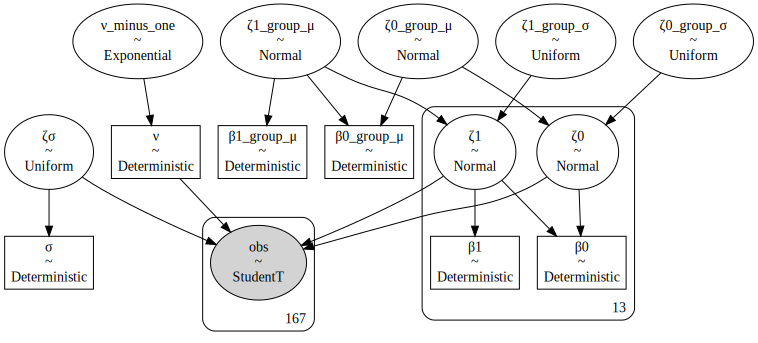

In [90]:
with pm.Model() as model_h2_linear:
    # Prior
    ζ0_group_μ = pm.Normal('ζ0_group_μ',mu=0,sigma=10)
    ζ1_group_μ = pm.Normal('ζ1_group_μ',mu=0,sigma=10)
    ζ0_group_σ = pm.Uniform('ζ0_group_σ',lower=1/1000,upper=1000)
    ζ1_group_σ = pm.Uniform('ζ1_group_σ',lower=1/1000,upper=1000)
    
    ζσ = pm.Uniform('ζσ',lower=1/1000,upper=1000)
    ν_minus_one = pm.Exponential('ν_minus_one',lam=1/29)
    ν = pm.Deterministic('ν',ν_minus_one+1)
    
    ζ0 = pm.Normal('ζ0',mu=ζ0_group_μ, sigma=ζ0_group_σ, shape=len(communities))
    ζ1 = pm.Normal('ζ1',mu=ζ1_group_μ, sigma=ζ1_group_σ, shape=len(communities))
    
    
    pm.StudentT('obs',
            nu=ν,
            mu=ζ0[idxs]+ζ1[idxs]*V29,
            sigma=ζσ,
            observed=V31)
    
    #transforming data back
    β0 = pm.Deterministic('β0', (ζ0*sd_31) + m_31 - (ζ1*m_29*sd_31/sd_29))
    β1 = pm.Deterministic('β1', ζ1*sd_31/sd_29)
    
    
    β0_group_μ = pm.Deterministic('β0_group_μ', (ζ0_group_μ*sd_31) + m_31 - (ζ1_group_μ*m_29*sd_31/sd_29))
    β1_group_μ = pm.Deterministic('β1_group_μ', ζ1_group_μ*sd_31/sd_29)

    σ = pm.Deterministic('σ', ζσ)

pm.model_to_graphviz(model_h2_linear)

### Model arguments


The linear model represents the relationship between the protective and equitable style of governance for pull requests for individual communities and a group of the communities. The linear model is defined with equation `V29 = 𝛽0 + 𝛽1 * V31`. The equation contains the metric predicted V29, metric predictor V31, the intercept 𝛽0 and the slope 𝛽1.

Similar to H1, the prior distribution of the mean is chosen to be normal for mean per community and group. The scale parameter is set to a large uniform, so it has little relevance. The likelihood function also uses student-T for robust distribution.  
The parameters: scale (σ) and normalizer (v) is common for all communities.  
The observed data passed to the likelihood function are standardized. It was done to improve the performance of the sampling by making it easier for the algorithm to explore the parameter space. The mean and standard deviation of the data is shifted and shrunk to be close to 0. The results are transformed back to the original scale with a deterministic distribution. The standardization is done by having  
`(y - M_y)/SD_y = z_y = ζ_0 + ζ_1 * z_x`  
`z_x = (x - M_x)/SD_x`  
Solving for y gives:  
`y=β_0 + β_1x`  
`β_0=ζ_0 SD_y + M_y - ζ_1 M_x * SD_y / SD_x`  
`β_1=ζ_1 SD_y / SD_x`

β0_group_μ  and β1_group_μ are the parameters used to make a decision on the hypothesis regarding general trends. β_0 and β_1 are the parameters to evaluate to test if the hypothesis works on all communities.



## H2 Linear model, sampling

In [136]:
trace_h2_linear = getTrace(folderName_h2_linear, model_h2_linear, resample_h2_linear, h2_tune_size, h2_target_accept)  if h2_do_linear else None
trace_h2_inferencedata_linear = getInferenceData(trace_h2_linear, model_h2_linear)     if h2_do_linear else None

In [137]:
az.summary(trace_h2_linear) if h2_do_linear else None

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
ζ0_group_μ -0.000  0.153  -0.294    0.288      0.001    0.000   63607.0   
ζ1_group_μ -0.123  0.115  -0.342    0.093      0.001    0.000   43230.0   
ζ0[0]      -0.373  0.170  -0.692   -0.051      0.001    0.001   53302.0   
ζ0[1]       0.097  0.175  -0.230    0.430      0.001    0.000   92967.0   
ζ0[2]       0.016  0.272  -0.504    0.529      0.001    0.001   48822.0   
...           ...    ...     ...      ...        ...      ...       ...   
β1[11]     -0.042  0.120  -0.267    0.185      0.001    0.001   26881.0   
β1[12]     -0.164  0.193  -0.564    0.177      0.001    0.001   59823.0   
β0_group_μ  2.538  0.464   1.663    3.421      0.002    0.002   46411.0   
β1_group_μ -0.117  0.110  -0.325    0.089      0.001    0.000   43230.0   
σ           0.880  0.073   0.739    1.016      0.000    0.000   23152.0   

             ess_sd  ess_bulk  ess_tail  r_hat  
ζ0_group_μ  62728.0   61321.0   66909.0    1.0  
ζ1_group_μ  43230.0   41163.0   41984.0    1.0  
ζ0[0]       53302.0   53520.0   30861.0    1.0  
ζ0[1]       79227.0   91774.0  108891.0    1.0  
ζ0[2]       48822.0   47739.0   73608.0    1.0  
...             ...       ...       ...    ...  
β1[11]      26881.0   26217.0   74712.0    1.0  
β1[12]      46689.0   58893.0   67849.0    1.0  
β0_group_μ  46411.0   44907.0   44601.0    1.0  
β1_group_μ  43230.0   41163.0   41984.0    1.0  
σ           22776.0   22206.0   59016.0    1.0  

[62 rows x 11 columns]

In [146]:
var_names_h2_linear=['β0_group_μ','β1_group_μ','ν']
rope_h2_linear = [("β1_group_μ", (-1.5, -0.65)), ("β1",(-1.5, -0.65), 15, 10)]

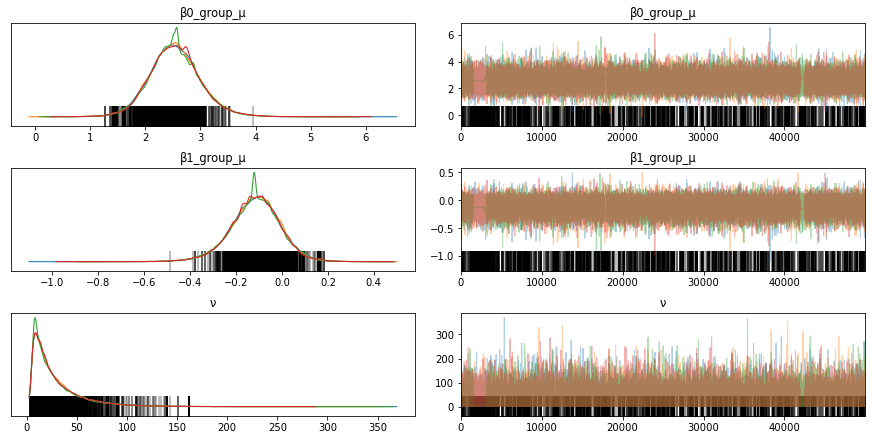

In [139]:
plot_trace_method2(trace_h2_linear, model_h2_linear, var_names_h2_linear)

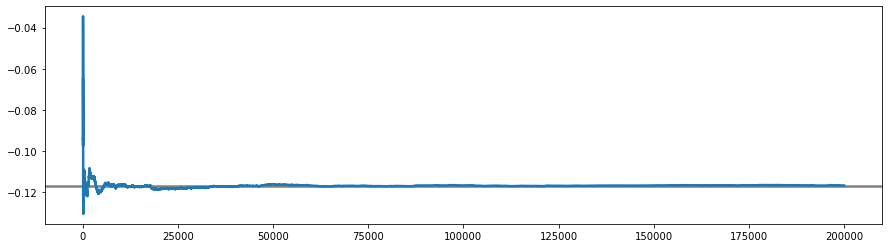

In [140]:
logtau = trace_h2_linear["β1_group_μ"]
mlogtau = [np.mean(logtau[:i]) for i in np.arange(1, len(logtau))]
plt.figure(figsize=(15, 4))
plt.axhline(-0.117, lw=2.5, color="gray")
plt.plot(mlogtau, lw=2.5)

#### Sampling effectiveness
R_hat was higher than 1 at \~1.02, but it was fixed by adding tuning steps and higher trace size.  
The effective sample size is quite low for many parameters including the slope and intercept of the group. Ess bulk / 200_000:  
- Β0_group_μ -	44907 
- Β1_group_μ -	41163
The mcse is consistenly low indicating an effective sampling.  

The visual check of convergence gotten with az.plot_trace method show that the chains are mostly overlapping with with only small differnces around the highest density. As there many black rugplot then there are divergences present. Some steps we have taken to reduce the impact of the divergences include increasing ammount tuned, increasing sample size and trying with an acceptance rate of 0.95 as pymc3 recommends and 0.99 when that didn't work well enough. Other efforts included decreasing and increasing the step_size which unfortunately only had negative effects on ammount of divergences.


## H2 linear model finds

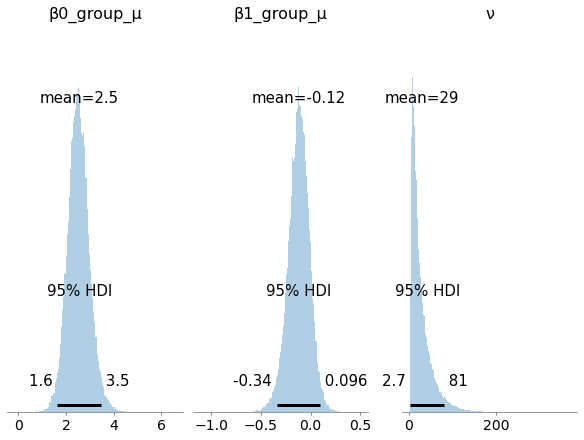

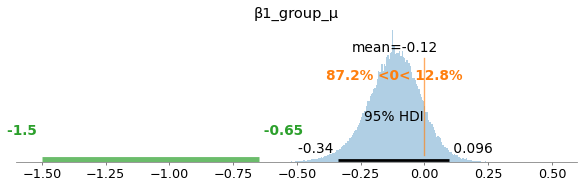

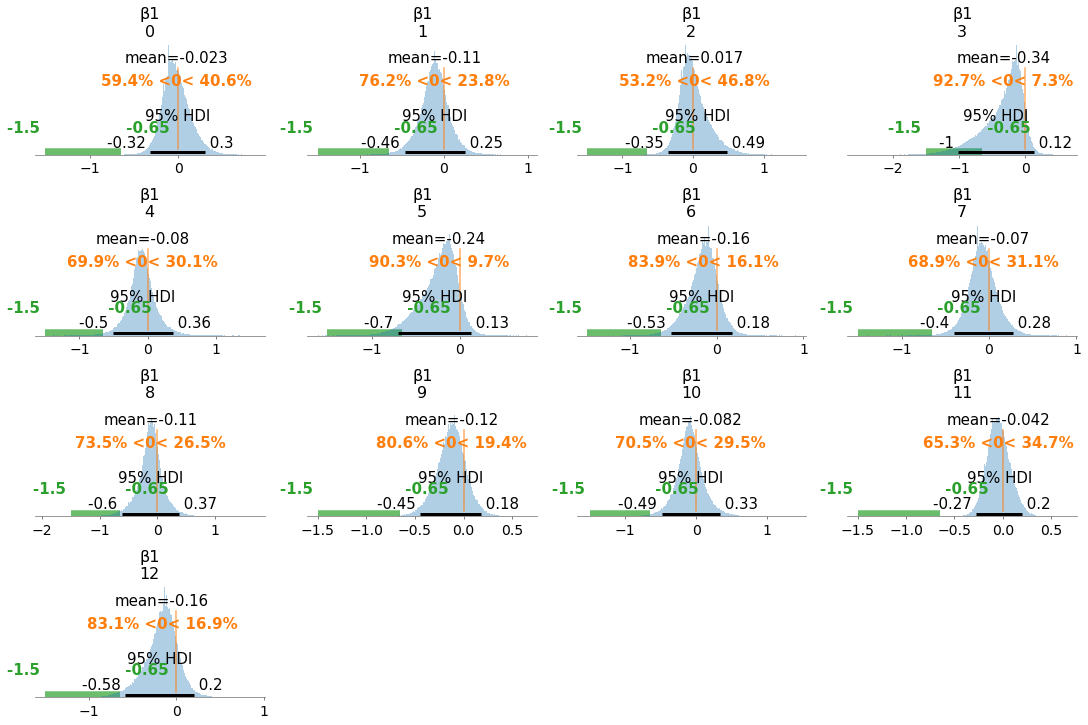

In [147]:
plot_trace_method1(trace_h2_inferencedata_linear, var_names_h2_linear, rope_h2_linear)

In [181]:
#plot_trace_scatter(trace_h2_linear, ['β0_group_μ','β1_group_μ'], 8, 5)

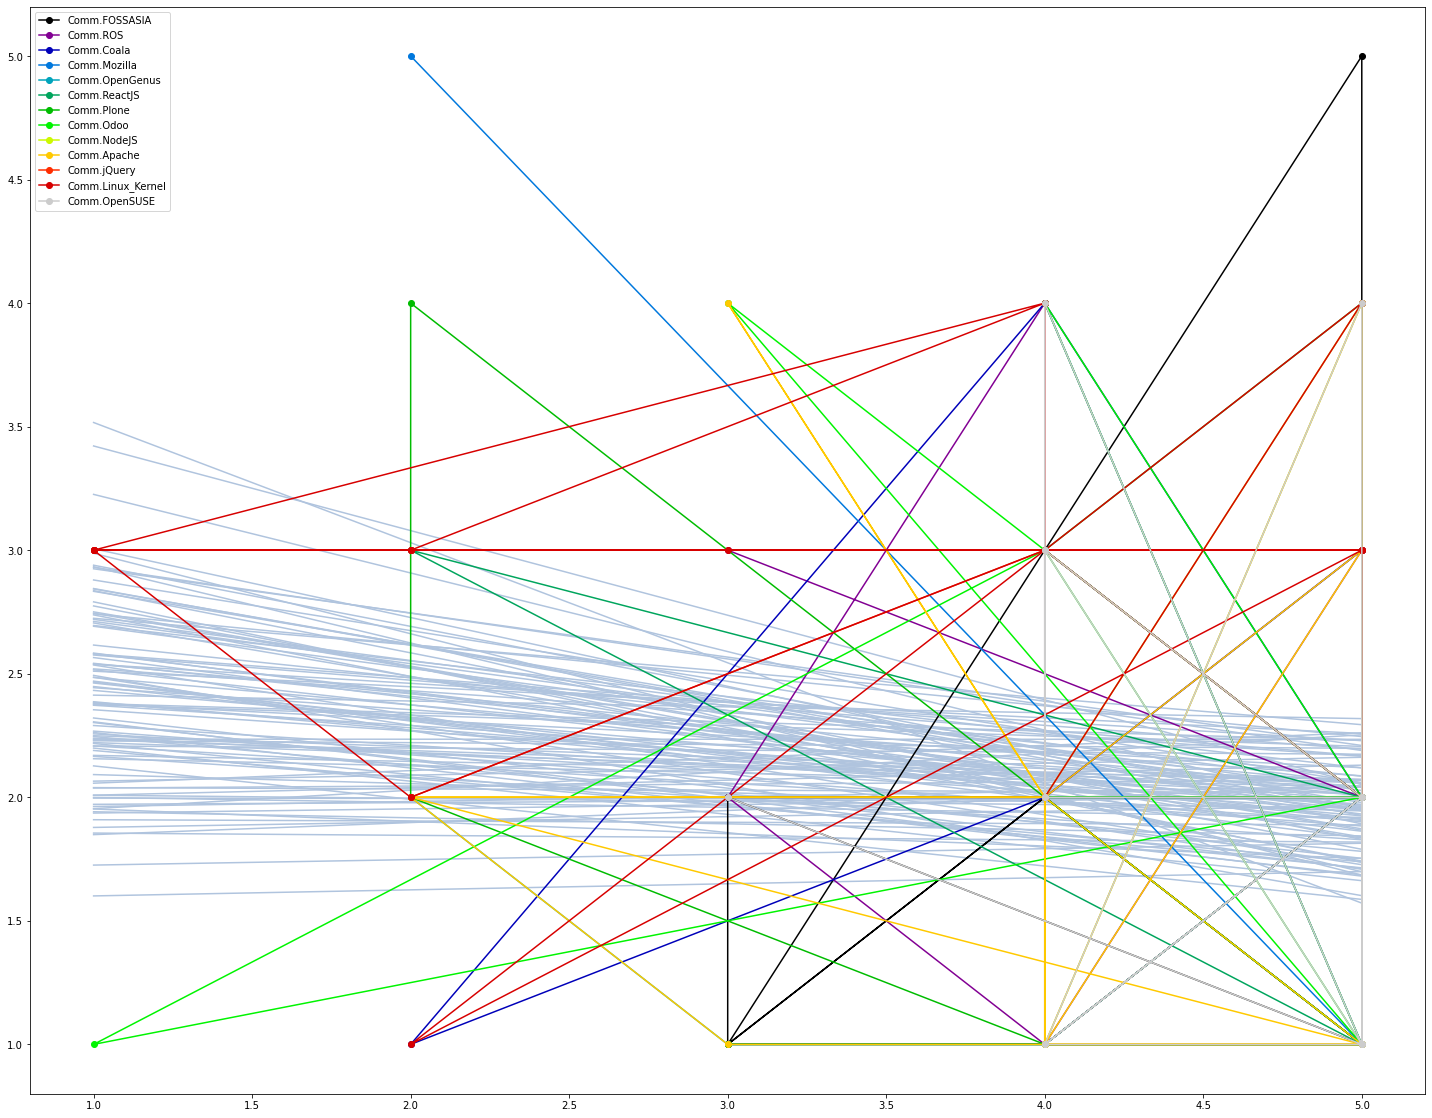

In [144]:
linFunction = lambda xprime, i: trace_h2_linear[i]['β0_group_μ']+trace_h2_linear[i]['β1_group_μ']*xprime
plot_all_data(linFunction)

C:\ProgramData\Miniconda3\lib\site-packages\arviz\stats\stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
C:\ProgramData\Miniconda3\lib\site-packages\arviz\stats\stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
C:\ProgramData\Miniconda3\lib\site-packages\arviz\stats\stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
C:\ProgramData\Miniconda3\lib\site-packages\arviz\stats\stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
C:\ProgramData\Minic

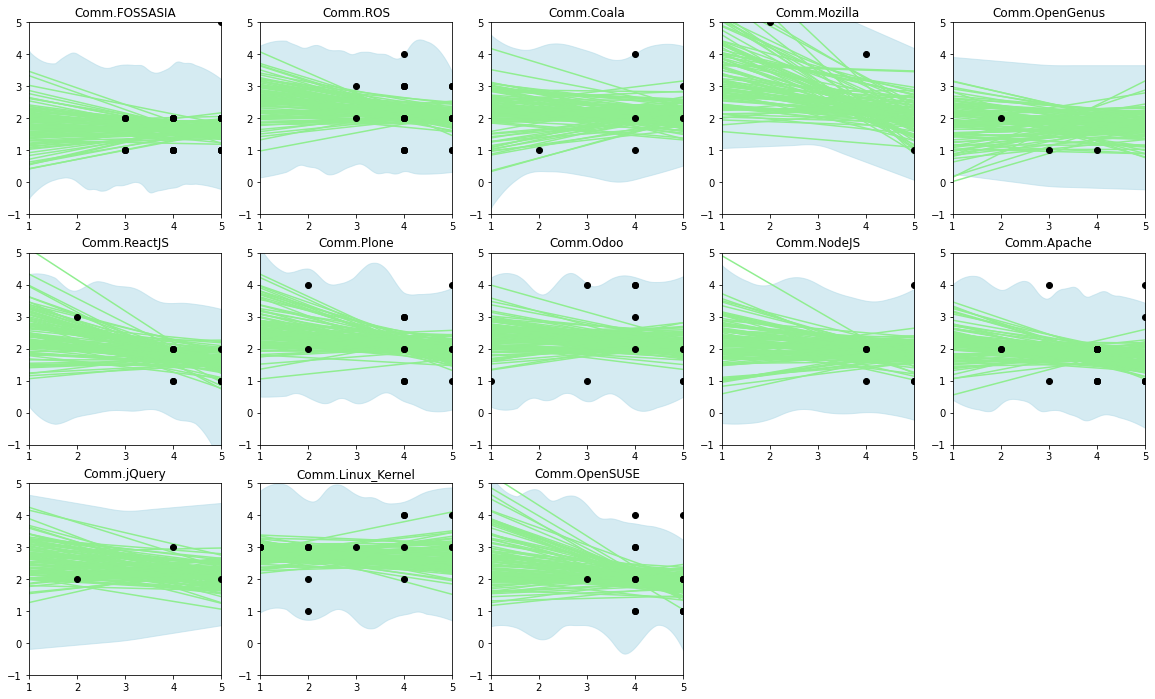

In [180]:
linFunction = lambda xprime, i, com_id: trace_h2_linear[i]['β0'][com_id]+trace_h2_linear[i]['β1'][com_id]*xprime
plot_individual(trace_h2_linear, linFunction)

### H2 linear model Acception / Rejection
The decision rules for the acceptance is that the mean of answers for V29 and V31 should be highly negatively correlated. 
- Slope convert low answers for V29 into high answers for V31 and high answers for V29 into low answers for V31.  
- Thus the rope for the slope is: smaller than or equal to - 0.65
0.65 was chosen as the minimum difference between the 2 values for V31 when one value for V29 is scored 1 and the other is scored 5 should be `2.5=(5*a+b)-(1*a+b)` for a≈0.65.  

The 95% HDI of the slope value for the group lies between -0.34 and 0.096, meaning it rejects the rope from -inf to -0.65 and thus there isn't a big enough linear dependency to accept the hypothesis.  
For almost every community the 95% HDI lies completely outside the rope. For the 2 that don't completely reject it the result is inconclusive as the 95% HDI and the rope have a minor overlap. Therefore it can be accepted that all communities don't show either a protective or equitable style of governance for PRs.

The acceptance/rejction only matters if the model actually captures the data, which the large model for all the communities seem indicate it does poorly. Looking at the individual models the data points does appear to be mostly inside the blue ranges, so it does appear to be a general trend line with some predictive capabilities. The range of the models are however very thick and thus isn't precise when predicting. The uncertanity of the models could be related to the few datapoints present in the data set. When looking at some of the green traces predicted many of the data points aren't being represented.


## Quadratic Model

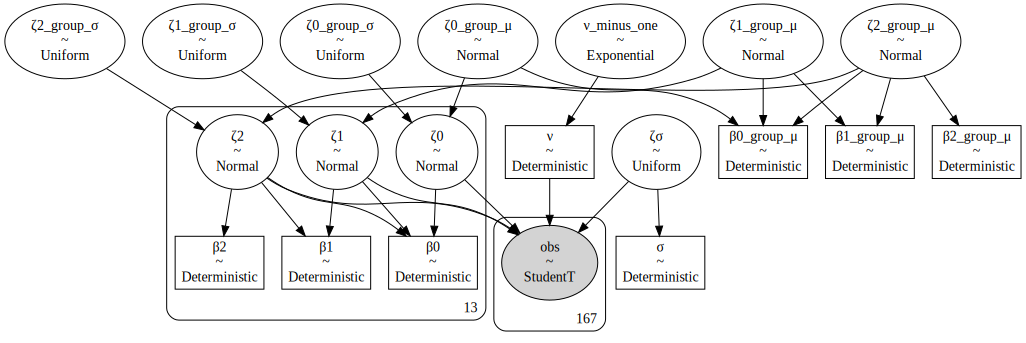

In [117]:
with pm.Model() as model_h2_quadratic:
    ζ0_group_μ = pm.Normal('ζ0_group_μ',mu=0,sigma=10)
    ζ1_group_μ = pm.Normal('ζ1_group_μ',mu=0,sigma=10)
    ζ2_group_μ = pm.Normal('ζ2_group_μ',mu=0,sigma=10)

    ζ0_group_σ = pm.Uniform('ζ0_group_σ',lower=1/1000,upper=1000)
    ζ1_group_σ = pm.Uniform('ζ1_group_σ',lower=1/1000,upper=1000)
    ζ2_group_σ = pm.Uniform('ζ2_group_σ',lower=1/1000,upper=1000)

    ζσ = pm.Uniform('ζσ',lower=1/1000,upper=1000)

    ν_minus_one = pm.Exponential('ν_minus_one',lam=1/29)
    ν = pm.Deterministic('ν',ν_minus_one+1)

    ζ0 = pm.Normal('ζ0',mu=ζ0_group_μ, sigma=ζ0_group_σ, shape=len(communities))
    ζ1 = pm.Normal('ζ1',mu=ζ1_group_μ, sigma=ζ1_group_σ, shape=len(communities))
    ζ2 = pm.Normal('ζ2',mu=ζ2_group_μ, sigma=ζ2_group_σ, shape=len(communities))

    pm.StudentT('obs',
                nu=ν,
                mu=ζ0[idxs]+ζ1[idxs]*V29+ζ2[idxs]*V29**2,
                sigma=ζσ,
                observed=V31)

    # Transform Data
    β2 = pm.Deterministic('β2', ζ2*sd_31/(sd_29**2))
    β1 = pm.Deterministic('β1', ζ1*sd_31/sd_29 - 2*ζ2*m_29*sd_31/(sd_29**2))
    β0 = pm.Deterministic('β0', ζ0*sd_31+m_31-ζ1*m_29*sd_31/sd_29+ζ2*(m_29**2)*sd_31/(sd_29**2))

    β2_group_μ = pm.Deterministic('β2_group_μ', ζ2_group_μ*sd_31/(sd_29**2))
    β1_group_μ = pm.Deterministic('β1_group_μ', ζ1_group_μ*sd_31/sd_29 - 2*ζ2_group_μ*m_29*sd_31/(sd_29**2))
    β0_group_μ = pm.Deterministic('β0_group_μ', ζ0_group_μ*sd_31+m_31-ζ1_group_μ*m_29*sd_31/sd_29+ζ2_group_μ*(m_29**2)*sd_31/(sd_29**2))

    σ = pm.Deterministic('σ', ζσ*sd_31)
pm.model_to_graphviz(model_h2_quadratic)

### Model Arguments

The quadratic models express the relationship of the style with a quadratic equation.  
`V29 = 𝛽0 + 𝛽1 * V31 + 𝛽2 * (V31)^2`  
It introduces an additional parameter, the quadratic coefficient  𝛽2 and when this coefficient is 0, it can also fit what the linear model can. The distributions used here are the same ones used in the linear model.  
The data from the model is standardized by: solving for y in the formula:  
`(y-M_y)/SD_y = z_y = ζ_0 + ζ_1 * z_x + ζ_2 * (z_x)^2`  
`z_x = (x-M_x)/SD_x`


## H2 quadratic model, sampling

In [118]:
trace_h2_quadratic = getTrace(folderName_h2_quadratic, model_h2_quadratic, resample_h2_quadratic, h2_tune_size, h2_target_accept)  if h2_do_quadratic else None
trace_h2_inferencedata_quadratic = getInferenceData(trace_h2_quadratic, model_h2_quadratic)        if h2_do_quadratic else None

Sequential sampling (4 chains in 1 job)
NUTS: [ζ2, ζ1, ζ0, ν_minus_one, ζσ, ζ2_group_σ, ζ1_group_σ, ζ0_group_σ, ζ2_group_μ, ζ1_group_μ, ζ0_group_μ]


Sampling 4 chains for 5_000 tune and 50_000 draw iterations (20_000 + 200_000 draws total) took 1685 seconds.
There were 2118 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9005734716178557, but should be close to 0.95. Try to increase the number of tuning steps.
There were 4112 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6142 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11436 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.85120956111205, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


In [119]:
az.summary(trace_h2_quadratic) if h2_do_quadratic else None

C:\ProgramData\Miniconda3\lib\site-packages\arviz\data\io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
ζ0_group_μ  0.022  0.170  -0.295    0.348      0.001    0.001   24648.0   
ζ1_group_μ -0.141  0.134  -0.399    0.105      0.001    0.001   20904.0   
ζ2_group_μ -0.018  0.094  -0.196    0.160      0.000    0.000   35507.0   
ζ0[0]      -0.362  0.189  -0.719   -0.007      0.001    0.001   29249.0   
ζ0[1]       0.102  0.191  -0.254    0.470      0.002    0.002   10126.0   
...           ...    ...     ...      ...        ...      ...       ...   
β0[12]      1.982  2.636  -3.284    6.960      0.011    0.008   57995.0   
β2_group_μ -0.016  0.085  -0.177    0.144      0.000    0.000   35507.0   
β1_group_μ -0.005  0.646  -1.233    1.221      0.003    0.003   39564.0   
β0_group_μ  2.372  1.241   0.074    4.794      0.006    0.004   41918.0   
σ           0.875  0.072   0.736    1.009      0.001    0.001    7959.0   

             ess_sd  ess_bulk  ess_tail  r_hat  
ζ0_group_μ  24648.0   22270.0   30781.0    1.0  
ζ1_group_μ  19066.0   20543.0   26435.0    1.0  
ζ2_group_μ  18719.0   34114.0   61607.0    1.0  
ζ0[0]       29249.0   29004.0   68294.0    1.0  
ζ0[1]        4685.0   10638.0    5923.0    1.0  
...             ...       ...       ...    ...  
β0[12]      52013.0   49540.0   75417.0    1.0  
β2_group_μ  18719.0   34114.0   61607.0    1.0  
β1_group_μ  29486.0   37643.0   68611.0    1.0  
β0_group_μ  41918.0   35524.0   75604.0    1.0  
σ            7959.0    7941.0   58515.0    1.0  

[91 rows x 11 columns]

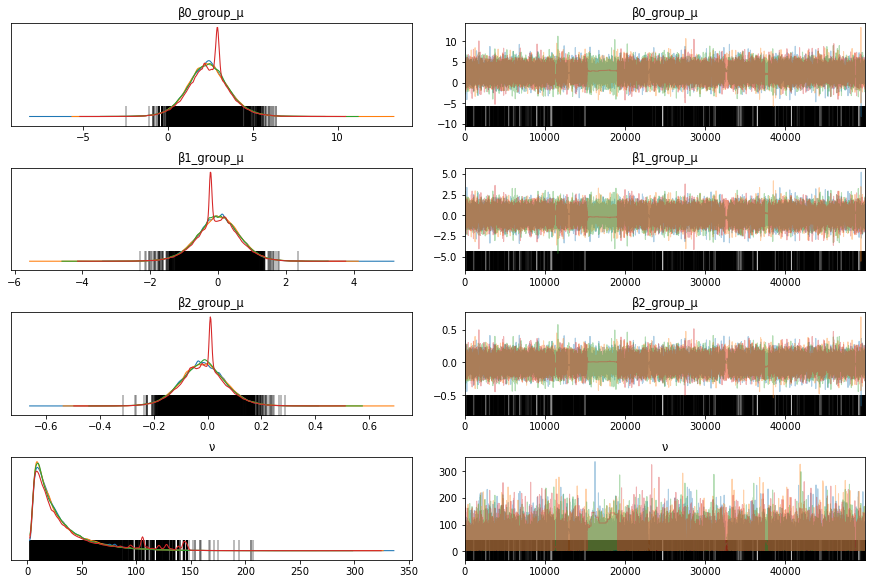

In [120]:
plot_trace_method2(trace_h2_quadratic, model_h2_quadratic, var_names_h2_quadratic)

#### Sampling effectiveness
Like with the sampling for the linear model the r_hat and msce is small indicating an effective sampling.  
The effective sample size is still high being above 80_000 for the most of the variables. for the 3 coefficients for the group, despite being smaller, they are still all above 30_000.  
Unforturnately the divergences for this sampling is quite high being above 1_000 for all chains. Visually, despite some few spikes, the chains appear to be overlapping nicely.


## H2 quadratic model finds

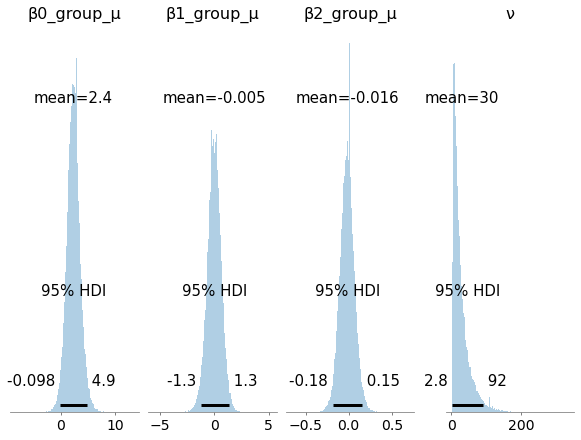

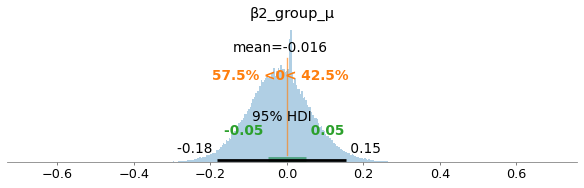

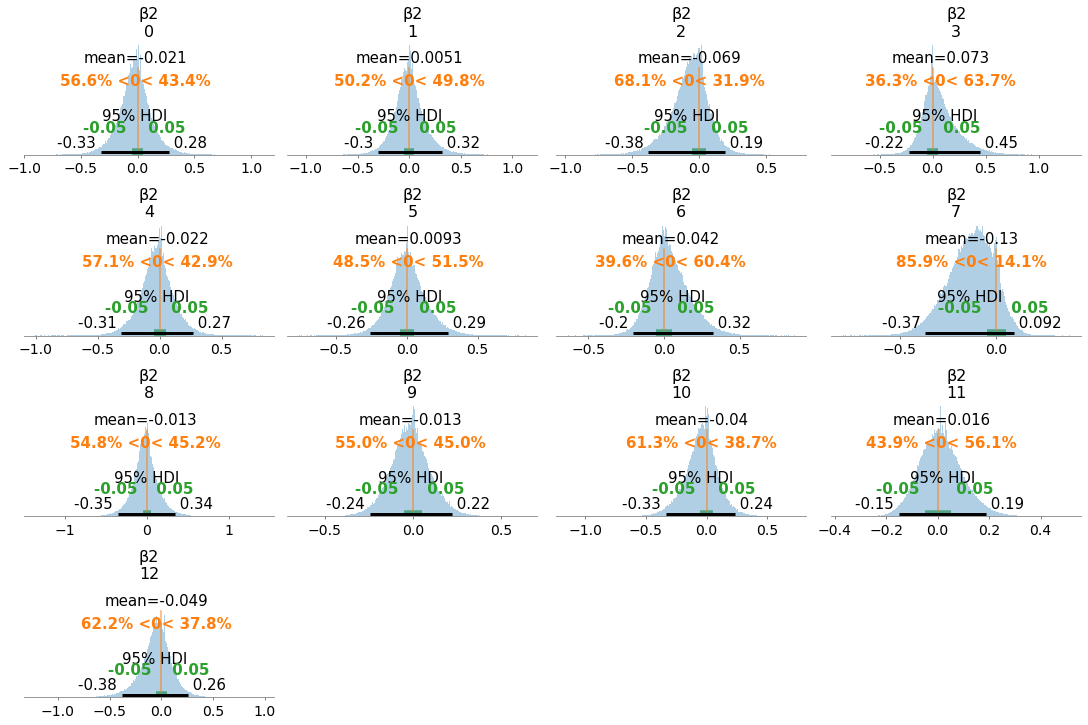

In [121]:
var_names_h2_quadratic=['β0_group_μ','β1_group_μ','β2_group_μ','ν']
rope_h2_linear_quadratic = [("β2_group_μ", (-0.05, 0.05)), ("β2",(-0.05, 0.05), 15, 10)]
plot_trace_method1(trace_h2_inferencedata_quadratic, var_names_h2_quadratic, rope_h2_linear_quadratic)

In [182]:
#plot_trace_scatter(trace_h2_quadratic, ['β0_group_μ','β1_group_μ','β2_group_μ'], 8, 5)

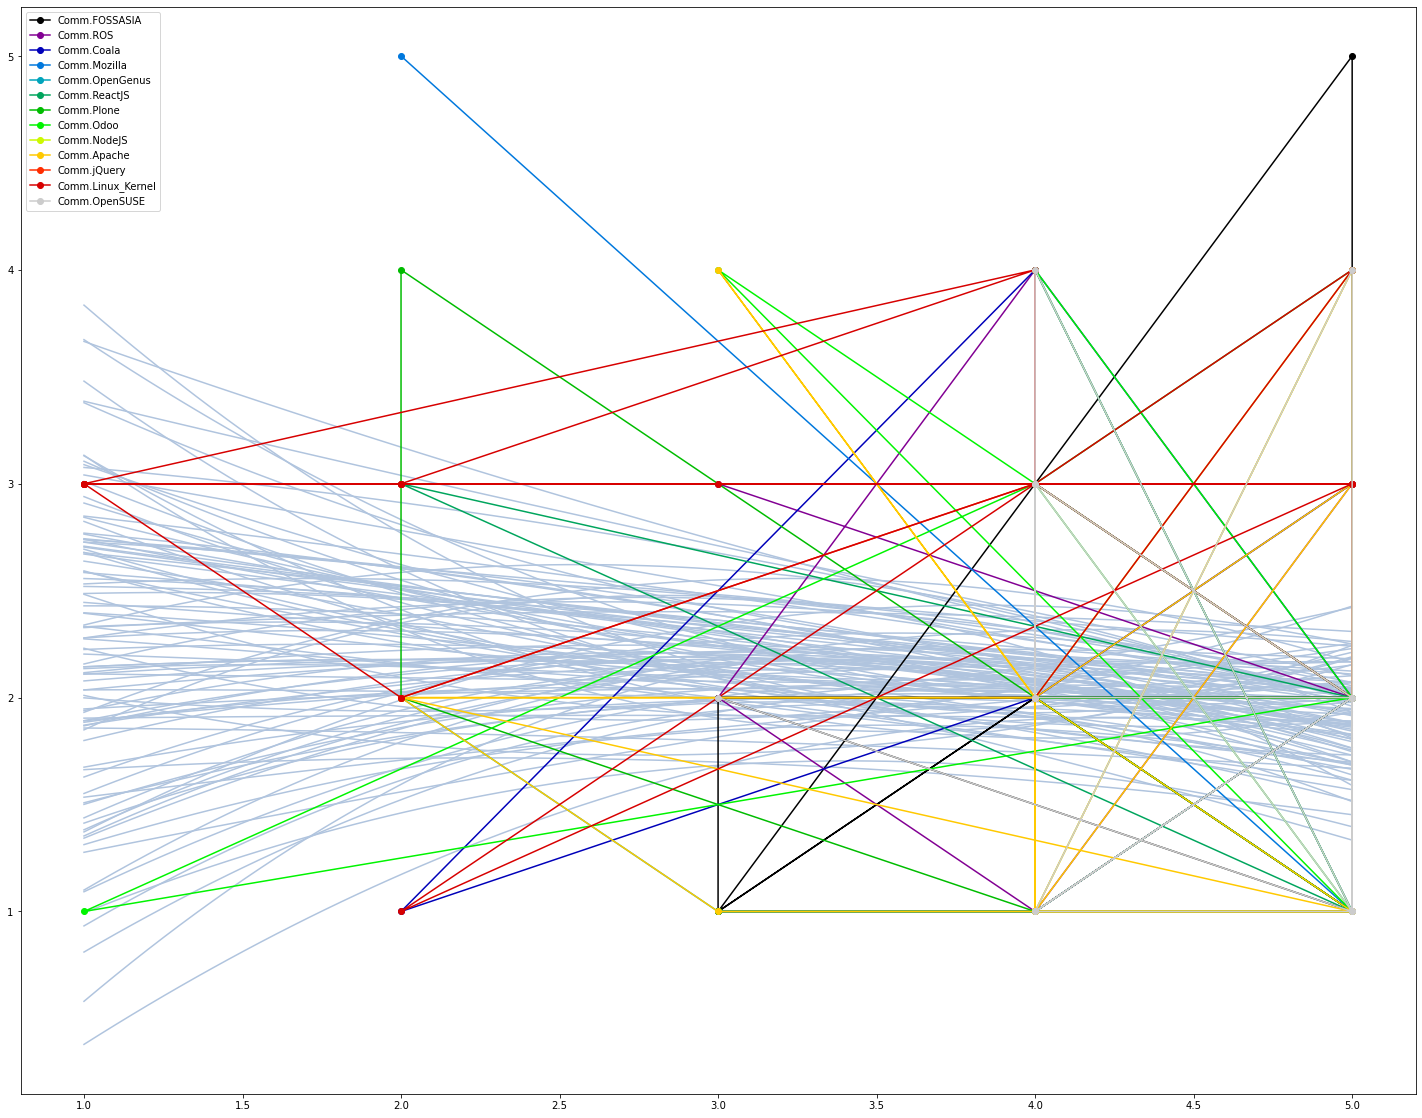

In [123]:
quadraticFunction = lambda xprime, i: trace_h2_quadratic[i]['β0_group_μ']+trace_h2_quadratic[i]['β1_group_μ']*xprime+trace_h2_quadratic[i]['β2_group_μ']*xprime**2
plot_all_data(quadraticFunction)

C:\ProgramData\Miniconda3\lib\site-packages\arviz\stats\stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
C:\ProgramData\Miniconda3\lib\site-packages\arviz\stats\stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
C:\ProgramData\Miniconda3\lib\site-packages\arviz\stats\stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
C:\ProgramData\Miniconda3\lib\site-packages\arviz\stats\stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
C:\ProgramData\Minic

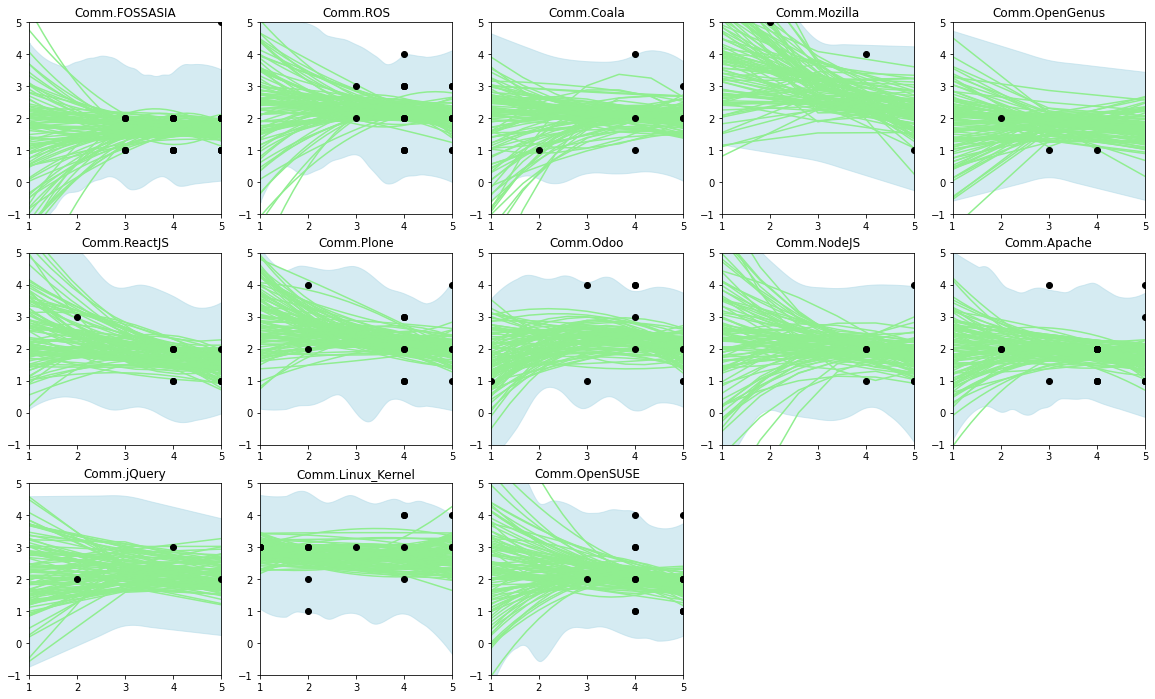

In [183]:
quadraticFunction = lambda xprime, i, com_id: trace_h2_quadratic[i]['β0'][com_id]+trace_h2_quadratic[i]['β1'][com_id]*xprime + trace_h2_quadratic[i]['β2'][com_id]*xprime**2
plot_individual(trace_h2_quadratic, quadraticFunction)

### H2 quadratic model - Acceptance / Rejection

If the credible values 𝛽2 in posterior are not close to 0, then we can conclude that the linear model was not adequate.  For this the rope chosen was 0+-0.05, as it then at least have an effect of 1, `1=(25*0.05)-(1*0.05)`. This means that if the rope is accepted, then the quadratic model provides an insignificant amount of more information.  
For the group coefficient Β2_group_μ and the individual coefficients Β2 it can be observed that the entire rope is within the 95% HDI, and thus it can be rejected that the quadratic provides only an insignificant amount of more information.  

#### Visual:
Looking at the individual models the data points appear to be mostly inside the blue ranges, so it does appear to be a general trend line. Although the range of the models have become a little more narrow thus more precise when predicting, it is still broad and imprecise. When comparing which datapoints the qudratic trace can predict with what the linear is able to, it becomes clear that it doesn't represent the data to a larger extent than what the linear model is capable of doing.  




Even when adding the more precise quadratic model there still doesn’t appear to be a negative slope which would be needed to conclude the hypothesis.

# Warnings
### sampling related
- `There were 2 divergences after tuning. Increase 'target_accept' or reparameterize.`  
  This problem as described above have been mitigated by increasing trace size, increasing tuning, and adding higher value to the 'target_accept' parameter. Higher 'target_accept' leads to smaller 'step_size' and also increases sampling time.
- `There were 11436 divergences after tuning. Increase 'target_accept' or reparameterize.
The acceptance probability does not match the target. It is 0.85120956111205, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.`  
  todo: after tuning size experiment

### Plotting
- `FutureWarning: Using 'from_pymc3' without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.`  
  This is just a warning for future versions, but making the suggested change didn't supress the warning.
- `FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions`  
  This is also a warning for future version, and it doesn't suggest a way to supress it.

# Division of group work
The vast majority of the code was made in full collaboration, with only a few plots and restructuring done individually. In regard to analyzing and arguing for models, sampling and so on the different sections was at first split up, but after rewriting and going through it would be erroneous to declare one had more responsibility than the other.
